In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
import matplotlib
import matplotlib.pyplot as plt
import pylab
import gensim
from sklearn.cluster import KMeans
import en_core_web_sm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import seaborn as sns
nlp = en_core_web_sm.load()

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


In [43]:
#helper functions
def preproccess(text):
    table = str.maketrans('', '', string.punctuation)
    words = [w.translate(table) for w in word_tokenize(text.lower())]
    words = [w for w in words if w.isalpha()]
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    lemmatizer = WordNetLemmatizer()
    words=[lemmatizer.lemmatize(w) for w in words]
    text=words[0]
    if len(words)>1:
        for word in words:
            text=text+' '+word
    return text
def read_corpus(df):
    for index, row in df.iterrows():
        yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(row['ideas']), [row['label']])
def elbow(X,model_type):
    distorsions = []
    for k in range(2, 20):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        distorsions.append(kmeans.inertia_)
    fig = plt.figure(figsize=(10, 5))
    plt.plot(range(2, 20), distorsions)
    plt.title('Elbow curve {}'.format(model_type))
def k_means_visualizaion(vec,name):
    kmeans = KMeans(n_clusters=5).fit(vec)
    vec_2d=TSNE().fit_transform(vec)
    colors = ['red','green','blue','purple','yellow']
    labels=kmeans.labels_
    label_colors=[]
    for label in labels:
        label_colors.append(colors[label])
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca()
    ax.set_xticks(np.arange(-70,70, 5))
    ax.set_yticks(np.arange(-70, 70, 5))
    plt.scatter(vec_2d[:, 0], vec_2d[:, 1], c=labels, cmap=matplotlib.colors.ListedColormap(colors))
    plt.grid()
    plt.title('{} map'.format(name))
    return [vec_2d,label_colors]
def return_idea_location(x_lower,x_higher,y_lower,y_higher,vec,labels,ideas):
    ideas_list=[]
    for i in range(len(vec)):
        if vec[i][0]>x_lower and vec[i][0]<x_higher and vec[i][1]>y_lower and vec[i][1]<y_higher:
            ideas_list.append([ideas[i],(vec[i][0],vec[i][1],),labels[i]])
    return ideas_list

In [15]:
#data loading and preproccesing
df=pd.read_csv('ideas.csv', encoding = "ISO-8859-1").fillna("")
df['ideas_un_process']=df['ideas']
df['ideas']= df.apply(lambda x: preproccess(x['ideas']),axis=1)
df.source_aggregated = pd.Categorical(df.source_aggregated)
df['label'] = df.source_aggregated.cat.codes

In [4]:
#preparing bag_of_words vector
bag_of_words_vec=CountVectorizer().fit_transform(df['ideas']).toarray()

#preparing doc2vec vector
corpus = list(read_corpus(df))
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(corpus)
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)
doc2vec_vec=[model.infer_vector(idea.words) for idea in corpus]

#preparing spacy cnn model vector
spacy_vec=df.ideas.apply(lambda x:nlp(x).vector).values.tolist()

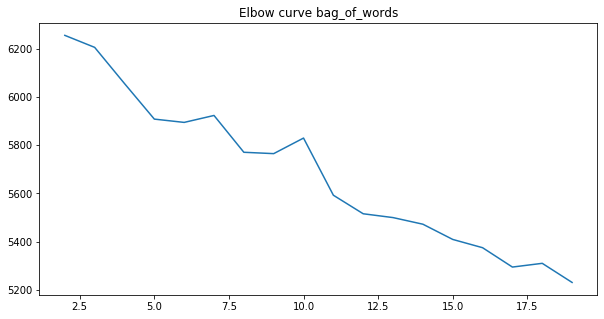

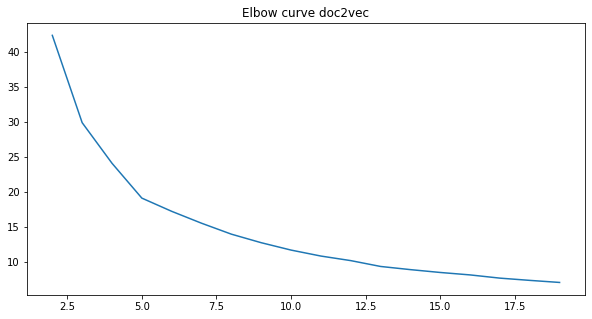

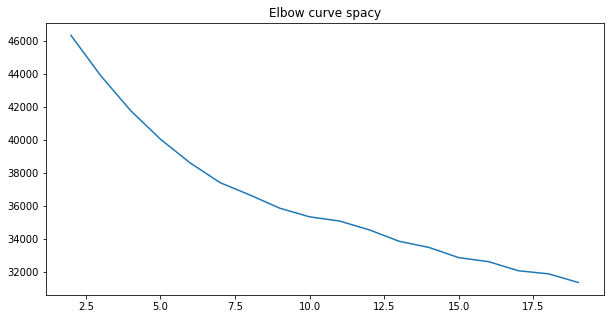

In [5]:
#visuzalize elbow method for k means on the vectors in order to choose best k
elbow(bag_of_words_vec,'bag_of_words')
elbow(doc2vec_vec,'doc2vec')
elbow(spacy_vec,'spacy')

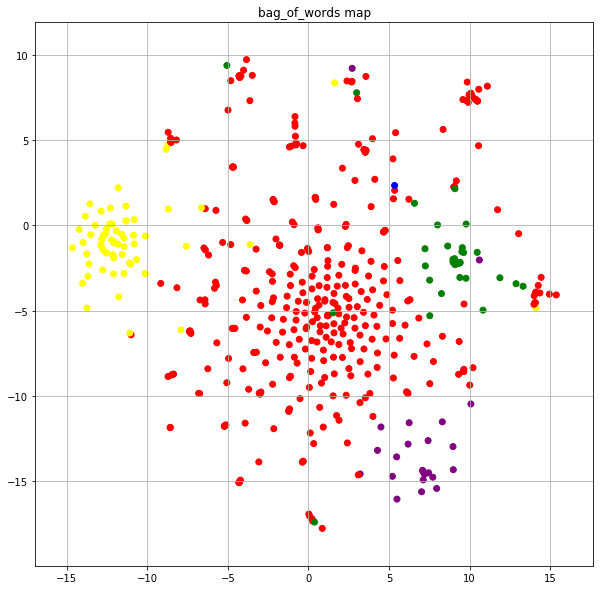

In [47]:
#base on elbow method we chose k=5, and preform k means clustering and visualize on with TSNE with colors as classes
bag_of_words_vec_2d=k_means_visualizaion(bag_of_words_vec,'bag_of_words')

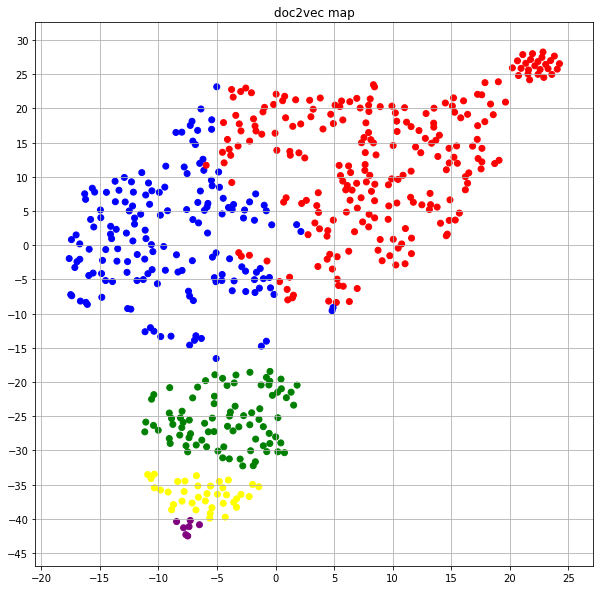

In [46]:
doc2vec_vec_2d=k_means_visualizaion(doc2vec_vec,'doc2vec')

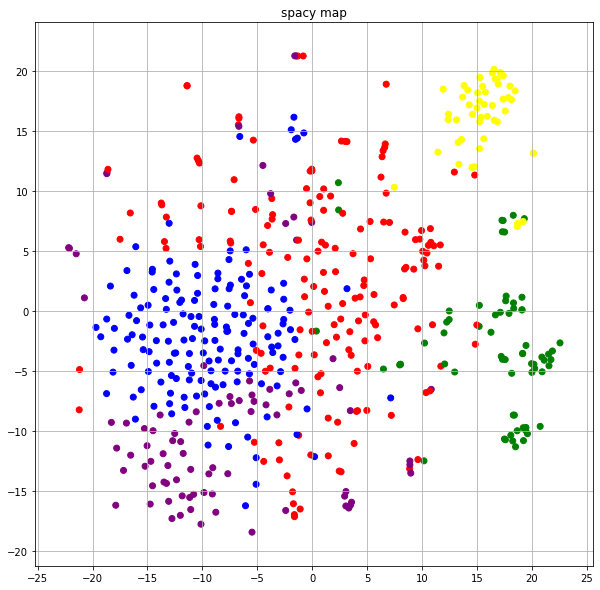

In [44]:
spacy_vec_2d=k_means_visualizaion(spacy_vec,'spacy')

# anlaysis of results

In [4]:
results=pd.read_csv('results.csv').dropna()
results['distance_example_real']=results.apply(lambda x: np.linalg.norm(np.array([x['x_example']-x['x_real'],x['y_example']-x['y_real']])),axis=1)
results['distance_example_user']=results.apply(lambda x: np.linalg.norm(np.array([x['x_example']-x['x'],x['y_real']-x['y']])),axis=1)

tmp1=results[['map','idea','idea_num','user']]
tmp1['distance']=results['distance_example_real']
tmp1['type']=results.apply(lambda x: 'example_real',axis=1)

tmp2=results[['map','idea','idea_num','user']]
tmp2['distance']=results['distance_example_user']
tmp2['type']=results.apply(lambda x: 'example_user',axis=1)

df=tmp1.append(tmp2)

C:\Users\vhalperi\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\vhalperi\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\vhalperi\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

C:\Users\vhalperi\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\vhalperi\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\vhalperi\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A

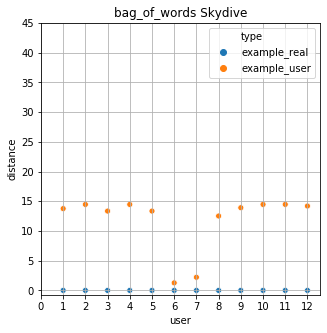

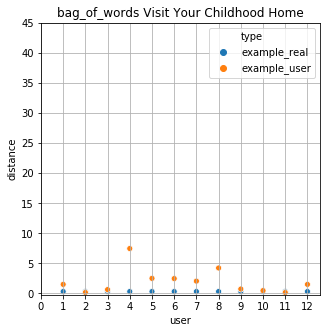

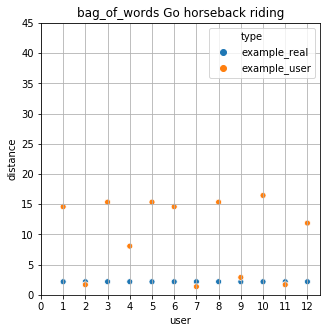

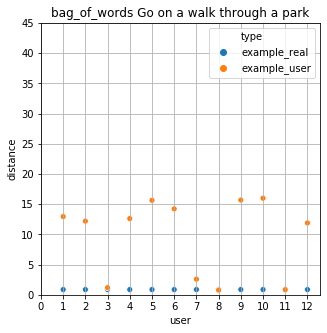

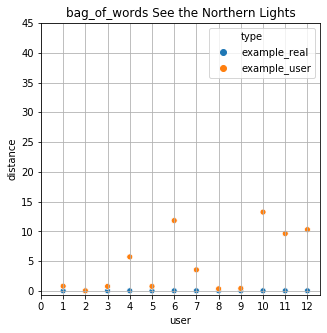

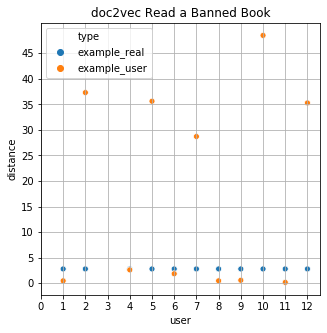

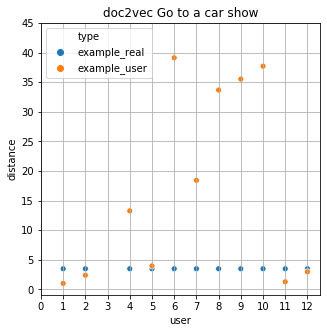

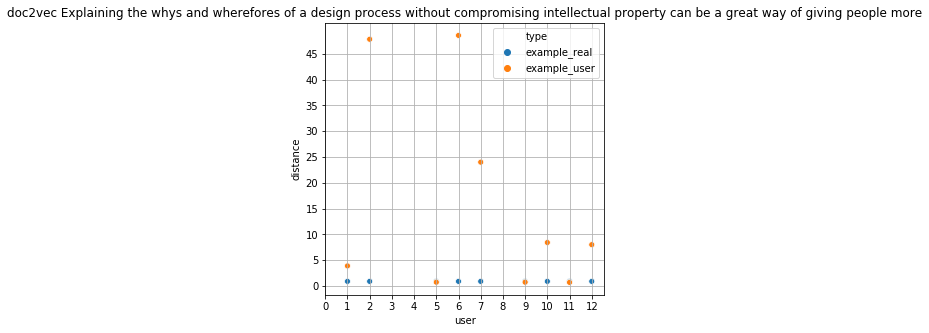

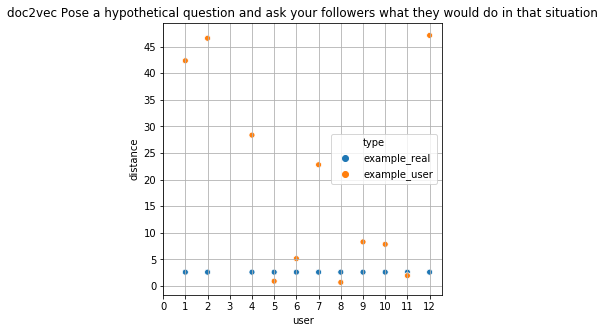

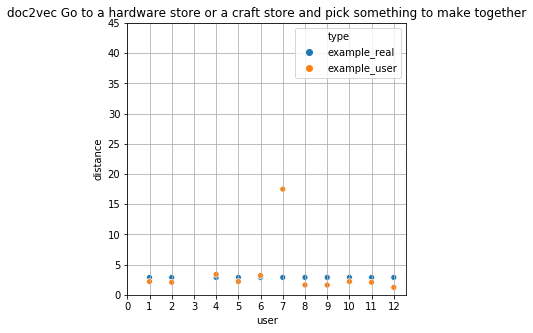

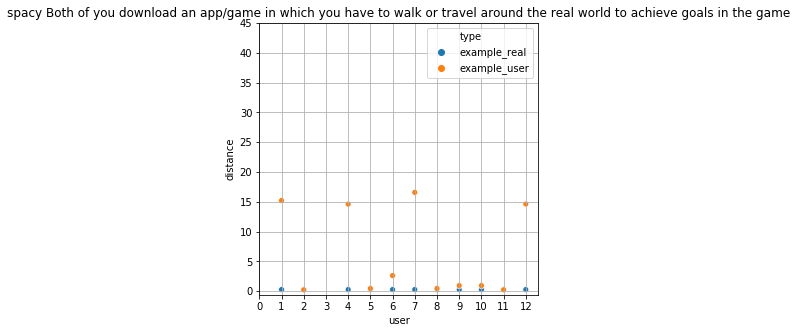

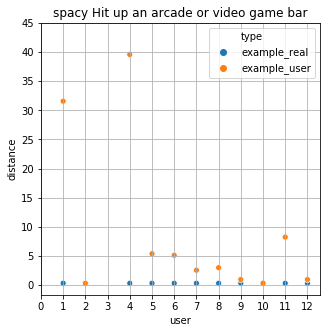

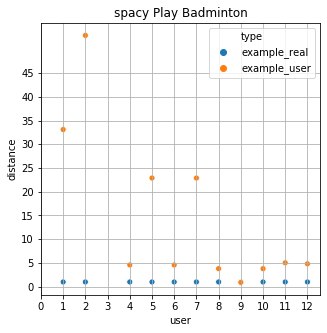

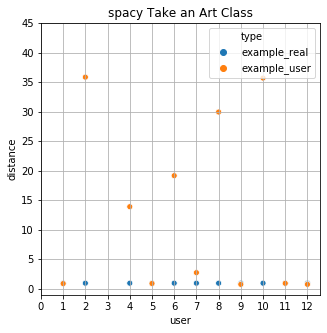

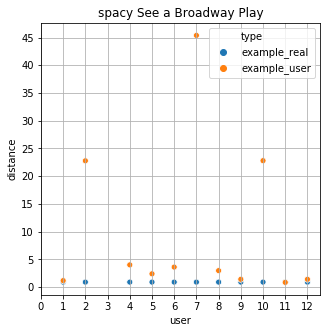

In [20]:
ideas=df['idea'].unique()
maps=df['map'].unique()
i=0
for i in range(len(ideas)):
    if i<5:
        j=0
    elif i<10:
        j=1
    else:
        j=2
    fig = plt.figure(figsize=(5, 5))
    ax = sns.scatterplot(x='user', y='distance',data=df[df['idea']==ideas[i]],hue='type')
    ax.set_xticks(np.arange(0,13, 1))
    ax.set_yticks(np.arange(0, 50, 5))
    plt.grid()
    plt.title(maps[j]+' '+ideas[i])
    fig.savefig(maps[j]+'_'+str(i)+'.png', dpi=fig.dpi)

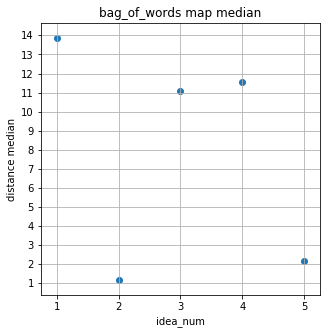

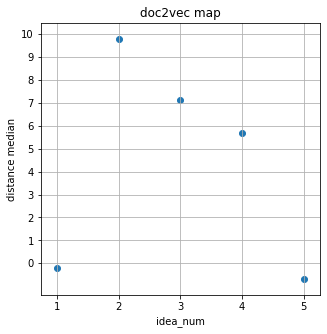

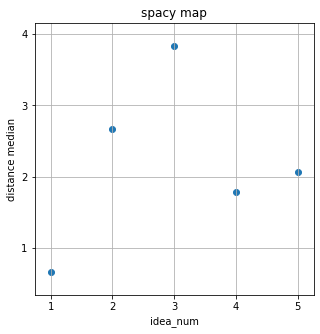

In [6]:
median_of_idea_bow_user=results[results['map']=='bag_of_words'].groupby('idea_num')['distance_example_user'].median()
median_of_idea_doc2vec_user=results[results['map']=='doc2vec'].groupby('idea_num')['distance_example_user'].median()
median_of_idea_spacy_user=results[results['map']=='spacy'].groupby('idea_num')['distance_example_user'].median()
median_of_idea_bow_real=results[results['map']=='bag_of_words'].groupby('idea_num')['distance_example_real'].median()
median_of_idea_doc2vec_real=results[results['map']=='doc2vec'].groupby('idea_num')['distance_example_real'].median()
median_of_idea_spacy_real=results[results['map']=='spacy'].groupby('idea_num')['distance_example_real'].median()
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
ax.set_xticks(np.arange(0,6, 1))
ax.set_yticks(np.arange(0, 15, 1))
plt.scatter(range(1,6), median_of_idea_bow_user-median_of_idea_bow_real)
plt.grid()
plt.xlabel('idea_num')
plt.ylabel('distance median')
plt.title('bag_of_words map median')
fig.savefig('bag_of_words_median.png', dpi=fig.dpi)

fig = plt.figure(figsize=(5,5))
ax = fig.gca()
ax.set_xticks(np.arange(0,6, 1))
ax.set_yticks(np.arange(0, 15, 1))
plt.scatter(range(1,6), median_of_idea_doc2vec_user-median_of_idea_doc2vec_real)
plt.grid()
plt.xlabel('idea_num')
plt.ylabel('distance median')
plt.title('doc2vec map')
fig.savefig('doc2vec_median.png', dpi=fig.dpi)

fig = plt.figure(figsize=(5,5))
ax = fig.gca()
ax.set_xticks(np.arange(0,6, 1))
ax.set_yticks(np.arange(0, 15, 1))
plt.scatter(range(1,6), median_of_idea_spacy_user-median_of_idea_spacy_real)
plt.grid()
plt.xlabel('idea_num')
plt.ylabel('distance median')
plt.title('spacy map')
fig.savefig('spacy_median.png', dpi=fig.dpi)